# Testfall

### Im Testfeld sind die Dimensionen vertauscht U[y,x]

In [1]:
#import
import numpy             as np
import matplotlib.pyplot as plt
import math
import sys
sys.path.insert(0, './')
import vtk_io.reader as vr
import os
#%load_ext autoreload
#%autoreload 2

#plot Eigenvectoren
def koos2(ma):
    w, v = np.linalg.eig(ma)
    #x
    v1x = [v[0,0], 0]
    v1y = [v[1,0], 0]
    v1 = np.array([v1x,v1y])
    plt.plot(v1[0,:],v1[1,:],'r-')
    #y
    v2x = [v[0,1], 0]
    v2y = [v[1,1], 0]
    v2 = np.array([v2x,v2y])
    plt.plot(v2[0,:],v2[1,:],'r-')
    plt.axis([-1.5,1.5, -1.5,1.5])
    ax = plt.gca()
    ax.set_autoscale_on(False)
    ax.set_aspect('equal')
    ax.grid(True, which='both')
    #axis
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    plt.show()
#Winkelbestimmung
#def alpha(v):
#    return math.acos(v[0,0] / np.linalg.norm(v[:,0]))
def alpha(u, v):
    return np.arctan2(v, u)
#Def Drehmatrix
def TramaQ(phi):
    return np.array([[np.cos(phi), np.sin(phi)], [-np.sin(phi), np.cos(phi)]])
#Drehung um alpha
def Trafo(phi, ma_in):
    return np.matmul(np.matmul(TramaQ(phi), ma_in), np.transpose(TramaQ(phi)))
#Drehung um alpha+45°
def TrafU(phi, ma_in):
    phi = phi+np.pi/4
    return np.matmul(np.matmul(TramaQ(phi), ma_in), np.transpose(TramaQ(phi)))

def vecfield(omega, R, lx, ly):
    x = np.linspace(0, lx-1, lx)
    y = np.linspace(0, ly-1, ly)
    X , Y  = np.meshgrid(x, y)
    Cx = 0.5*lx
    Cy = 0.5*ly
    U = 0.0*X
    V = 0.0*X
    r = ((X-Cx)**2 + (Y-Cy)**2)**0.5
    phi = alpha( X-Cx, Y-Cy )
    pos = np.where(r<R)
    U[pos] = -r[pos] * omega * np.sin(phi[pos])
    V[pos] =  r[pos] * omega * np.cos(phi[pos])
    return X,Y, U, V

X,Y,U,V = vecfield(2, 60, 540, 270)

##### lx = 120, ly = 80; horizontal: x, j; vertikal: y, i; U[i, j]

shape = np.shape(U)

#partial derivations
nabla = np.ndarray(shape=(shape[0],shape[1], 2 ,2), dtype=float)                       

# i(y): 0-79; j(x): 0-119

for i in range(0,shape[0]):                              
    for j in range(1,shape[1]):                        
        nabla[i,j,0,0] = (U[i,j] - U[i,j-1]) / 0.001  
    nabla[i,0,0,0] = 0
    #u_x[i,0] = 0  
    
for j in range(0,shape[1]):                              
    for i in range(1,shape[0]):                        
        nabla[i,j,0,1] = (U[i,j] - U[i-1,j]) / 0.001       
    nabla[0,j,0,1] = 0
    #u_y[0,j] = 0    
    
for i in range(0,shape[0]):                              
    for j in range(1,shape[1]):                        
        nabla[i,j,1,0] = (V[i,j] - V[i,j-1]) / 0.001  
    nabla[i,0,1,0] = 0
    #v_x[i,0] = 0
    
for j in range(0,shape[1]):                              
    for i in range(1,shape[0]):                        
        nabla[i,j,1,1] = (V[i,j] - V[i-1,j]) / 0.001       
    nabla[0,j,1,1] = 0
    #v_y[0,j] = 0
    


# nabla
#nabla = np.ndarray(shape=(shape[0],shape[1], 2, 2), dtype=float)
#for i in range(0,shape[0]):                              # nabla = [[u_x, u_y], [v_x, v_y]]
 #   for j in range(0,shape[1]): 
  #      nabla[i,j,0,0] = u_x[i,j]
   #     nabla[i,j,0,1] = u_y[i,j]
    #    nabla[i,j,1,0] = v_x[i,j]
     #   nabla[i,j,1,1] = v_y[i,j]

S = np.ndarray(shape=(shape[0], shape[1], 2, 2))        
for i in range(0,shape[0]):                           
    for j in range(0,shape[1]): 
        S[i,j,0,0] = nabla[i,j,0,0]
        S[i,j,0,1] = (nabla[i,j,0,1] + nabla[i,j,1,0]) * 0.5
        S[i,j,1,0] = (nabla[i,j,0,1] + nabla[i,j,1,0]) * 0.5
        S[i,j,1,1] = nabla[i,j,1,1]

w, v = np.linalg.eig(S)

### nabla_BRF

nabla_BRF = np.ndarray(shape=(shape[0], shape[1], 2, 2)) 
for i in range(0,shape[0]):                           
    for j in range(0,shape[1]): 
        nabla_BRF[i,j] = TrafU( alpha(v[i,j,0,0], v[i,j,1,0]), nabla[i,j] )

### nabla_RES

nabla_RES = np.ndarray(shape=(shape[0], shape[1], 2, 2)) 
for i in range(0,shape[0]):                           
    for j in range(0,shape[1]): 
        nabla_RES[i,j,0,0] = nabla_BRF[i,j,0,0]
        nabla_RES[i,j,0,1] = np.sign(nabla_BRF[i,j,0,1]) * np.minimum(np.absolute(nabla_BRF[i,j,0,1]), np.absolute(nabla_BRF[i,j,1,0]))
        nabla_RES[i,j,1,0] = np.sign(nabla_BRF[i,j,1,0]) * np.minimum(np.absolute(nabla_BRF[i,j,0,1]), np.absolute(nabla_BRF[i,j,1,0]))
        nabla_RES[i,j,1,1] = nabla_BRF[i,j,1,1]

#Omega
Omega_RES = np.ndarray(shape=(shape[0], shape[1], 2, 2))
for i in range(0,shape[0]):                           
    for j in range(0,shape[1]): 
        Omega_RES[i,j,0,0] = 0
        Omega_RES[i,j,0,1] = 0.5 * (nabla_RES[i,j,0,1] - nabla_RES[i,j,1,0])
        Omega_RES[i,j,1,0] = 0.5 * (nabla_RES[i,j,1,0] - nabla_RES[i,j,0,1])
        Omega_RES[i,j,1,1] = 0

#omega_RR
omega_RR = np.ndarray(shape=(shape[0], shape[1]))
for i in range(0,shape[0]):                           
    for j in range(0,shape[1]): 
        omega_RR[i,j] = Omega_RES[i,j,1,0] - Omega_RES[i,j,0,1]

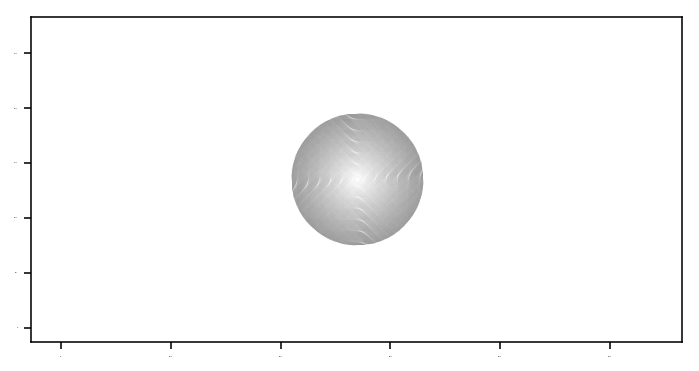

In [9]:
from matplotlib import rcParams
rcParams.update({'font.size': 1})
rcParams['figure.dpi'] = 200   # have figure show up at reasonable size in the notebook

fig, ax = plt.subplots()
#im = plt.imshow(u_skr, cmap='binary', interpolation='nearest')
Q = ax.quiver(X, Y, U, V, width = 0.0001, scale = 10000)  
ax.set(aspect=1)
#cbar = plt.colorbar(im)

plt.show()
#fig.savefig('foo.png', dpi=2160, format='png')

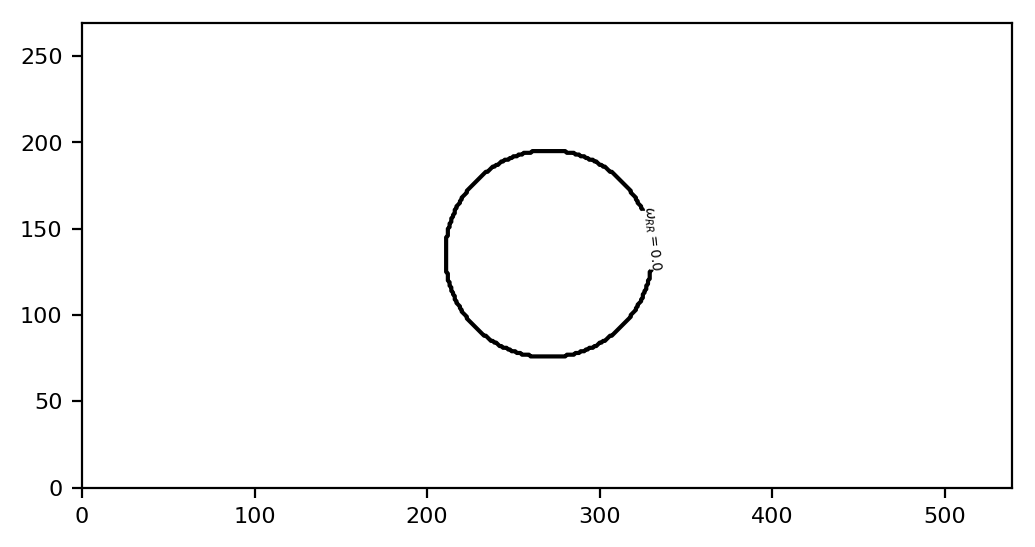

In [5]:
from matplotlib import rcParams
rcParams.update({'font.size': 8})
rcParams['figure.dpi'] = 200   # have figure show up at reasonable size in the notebook
ones = np.ones([shape[0],shape[1]])

fig, ax = plt.subplots()

#ax.quiver(X, Y, omega_RR, ones, scale = 800000)
#ax.set(aspect=1, title='Quiver Plot')

cont = ax.contour(X, Y, omega_RR, levels=[0], colors='k')
plt.clabel(cont, inline=1, fontsize=5, fmt=r'$\omega_{RR} = 0.0$') #
ax.set(aspect=1)
plt.show()

#cbar = plt.colorbar(im)

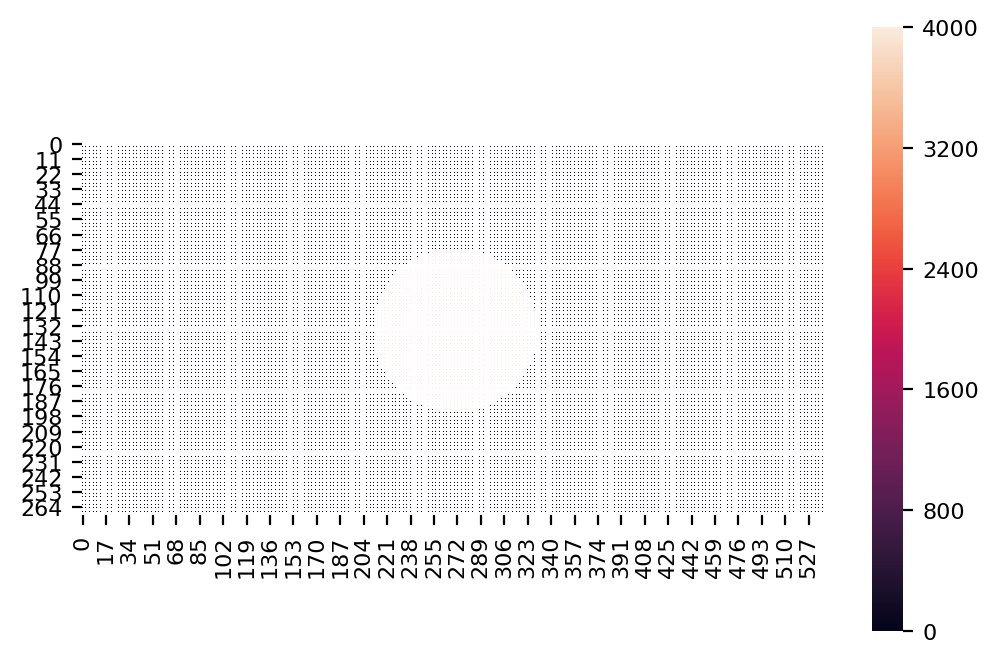

In [7]:
import seaborn as sns
ax = sns.heatmap(omega_RR, linewidth=0.01)
ax.set(aspect=1)
plt.show()